In [1]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample


from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Create data frame of annotation info

In [3]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(1084, 13)
Int64Index([], dtype='int64')
(1084, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,533,5,low slug,46305.0,32714.904,0.368722,39977.724643,9966.541464,2.313672,9.578221,0.000271,37978.838411
1,1,533,5,low slug,149692.5,43037.465,0.306856,37931.297975,20543.321215,4.308415,22.308306,-0.000239,36034.733076
2,2,533,5,low slug,243157.5,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566
3,3,533,5,low slug,243270.0,63014.450,0.232295,32242.081971,21947.090189,5.325133,33.372614,-0.000671,30629.977872
4,4,533,5,low multi,295560.0,74933.164,0.206291,17095.059221,11740.918797,5.372725,34.224633,-0.001093,16240.306260


In [4]:
annot_features_full = annot_features_full[annot_features_full['Annotation'] != 'noise']

In [5]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                             Animal                                                            Group                                              time_stamp                                                                                     power_sum                                                                                             spec_pur                                                                       spec_cent                                                                                                   spec_spread                                                                                                         spec_skew                                                                       spec_kurt                                                                              spec_slope                                                                       spec_roll                              \
                count        mean         std   min     25%    50%     75%    max  count        mean        std    min    25%    50%    75%    max  count      mean       std  min  25%  50%  75%  max      count           mean            std      min         25%        50%         75%       max     count           mean            std        min           25%          50%          75%        max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max       count           mean            std           min            25%            50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std        min        25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean           std   
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
bbc              16.0   81.875000   26.181100  21.0   76.25   84.5  101.75  107.0   16.0  551.125000   8.724487  534.0  543.0  554.0  559.0  559.0   16.0  4.437500  0.512348  4.0  4.0  4.0  5.0  5.0       16.0  222723.281250  161859.049561  13590.0  117303.750  196908.75  301685.625  535702.5      16.0  204078.307625  193322.116804  65204.582  118303.71000  157959.0050  179809.2375   872012.6     16.0  0.101816  0.046395  0.026119  0.085418  0.089934  0.118413  0.219365      16.0  31369.661776   3408.032166  25428.290261  29530.387395  31273.059220  33965.217581  36864.114756        16.0  154295.504440   45887.605222  82643.398891  124006.380527  157006.199597  171826.955013  272975.403907      16.0  4.301428  0.821950  3.272398  3.639845  4.074513  4.857638  5.614859      16.0  19.744209   8.720991  10.020710  12.778336  17.275809  25.393034  34.627316       16.0 -0.002649  0.000134 -0.002793 -0.002730 -0.002686 -0.002620 -0.002319      16.0  29801.178687   3237.630558   
high multi        5.0   60.800000   34.981424  10.0   53.00

In [12]:
#separate and save for later testing dataset
train_orig, test_orig = train_test_split(annot_features_full, test_size=0.3, random_state=1, stratify = annot_features_full.Annotation)

In [38]:
train_orig_maj = train_orig[train_orig['Annotation'] == 'rand_noise']
train_orig_min = train_orig[train_orig['Annotation'] != 'rand_noise']

train_orig_min_upsamples = resample(train_orig_min, replace=True, n_samples = len(train_orig_maj), random_state = 123)

train_orig_upsamples = pd.concat([train_orig_min_upsamples, train_orig_maj])

print(train_orig_upsamples.Annotation.value_counts())

train_orig_upsamples.head()

rand_noise    630
low slug      362
bbc           107
low multi      98
high slug      35
high multi     28
Name: Annotation, dtype: int64


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
89,89,554,4,low multi,455805.0,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517
28,28,535,5,low multi,22927.5,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713
67,67,542,4,low slug,378922.5,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470
96,96,555,4,low slug,260842.5,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800
56,56,535,5,high multi,442462.5,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329


In [19]:
groups = train_orig_upsamples['Unnamed: 0'].values
annot_labels_up = train_orig_upsamples['Annotation']
annot_labels_up.replace(regex={r'low slug': 1, 'high slug': 1, 'low multi': 1, 'high multi': 1, 'bbc': 1, 'noise': 0, 'rand_noise': 0}, inplace=True)

In [20]:
annot_features_up = train_orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
annot_features_up.head()

,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
89,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517
28,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713
67,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470
96,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800
56,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329


In [21]:
group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(annot_features_up, annot_labels_up, groups))

In [22]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

In [23]:
#skf = StratifiedKFold(n_splits=3)
#lr_cv.fit(features_scaled, annot_labels)
#print("Test set accuracy of LR model: ",lr_cv.score(features_scaled, annot_labels))

lr_cv = LogisticRegression(random_state=0)

y_pred = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat = confusion_matrix(annot_labels_up, y_pred)
conf_mat

C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local

array([[469, 161],
       [136, 494]], dtype=int64)

In [26]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred))
print("F1:", metrics.f1_score(annot_labels_up,y_pred))

Sensitivity/Recall (TPR):  0.7841269841269841
Precision (PPV):  0.7541984732824427
Accuracy:  0.7642857142857142
F1: 0.7688715953307393


In [28]:
print("Classification Report:\n", metrics.classification_report(annot_labels_up,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76       630
           1       0.75      0.78      0.77       630

   micro avg       0.76      0.76      0.76      1260
   macro avg       0.76      0.76      0.76      1260
weighted avg       0.76      0.76      0.76      1260



In [29]:
metrics.roc_auc_score(annot_labels_up, y_pred_prob[:,1])

0.8364550264550265

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

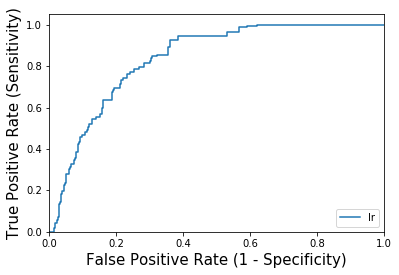

In [30]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(annot_labels_up, y_pred_prob[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

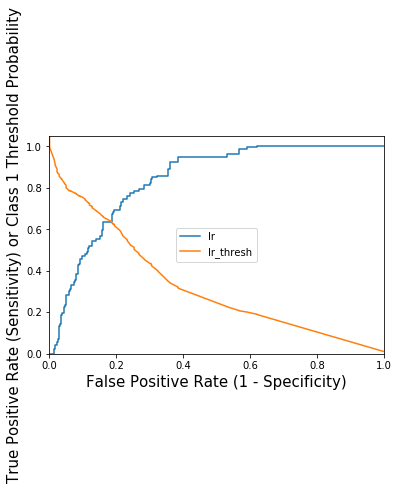

In [31]:
# plot LR and RF model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_lr,thresholds_lr, label="lr_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

No handles with labels found to put in legend.


Text(0, 0.5, 'Precision')

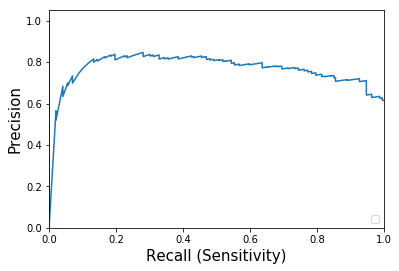

In [33]:
# calculate precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(annot_labels_up, y_pred_prob[:,1])
plt.plot(recall, precision, label='')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

In [40]:
train_orig_upsamples['pred'] = y_pred
train_orig_upsamples.head()

,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,pred
89,89,554,4,low multi,455805.0,694039.750,0.030332,12541.676333,27137.780162,5.623633,34.410220,-0.001651,11914.592517,1
28,28,535,5,low multi,22927.5,406942.280,0.060241,14620.335487,18088.471048,3.414490,11.367971,-0.001720,13889.318713,1
67,67,542,4,low slug,378922.5,40671.613,0.310423,38616.352074,14487.946302,4.189622,23.269604,-0.000063,36685.534470,0
96,96,555,4,low slug,260842.5,59212.484,0.251303,25224.451368,14167.187906,4.905265,26.451452,-0.000701,23963.228800,1
56,56,535,5,high multi,442462.5,353085.720,0.077175,22611.237189,55375.261042,5.337826,32.817694,-0.001653,21480.675329,1


In [41]:
train_orig_upsamples.groupby('Annotation')['pred'].describe()

,count,mean,std,min,25%,50%,75%,max
Annotation,,,,,,,,
bbc,107.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
high multi,28.0,0.678571,0.475595,0.0,0.0,1.0,1.0,1.0
high slug,35.0,0.828571,0.382385,0.0,1.0,1.0,1.0,1.0
low multi,98.0,0.918367,0.275212,0.0,1.0,1.0,1.0,1.0
low slug,362.0,0.687845,0.464014,0.0,0.0,1.0,1.0,1.0
rand_noise,630.0,0.255556,0.436520,0.0,0.0,0.0,1.0,1.0


In [ ]:
k_range = range(2,10)
scores = []
for k in k_range:
    print(k)
    km_ss = KMeans(n_clusters=k, random_state=19)
    km_ss.fit(features_scaled)
    scores.append(silhouette_score(features_scaled, km_ss.labels_))
    print(scores)

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=2,random_state=19)
km2.fit(features_scaled)
score = silhouette_score(features_scaled, km_ss.labels_)
annot_features_full['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

In [ ]:
annot_features_full.groupby('Annotation')['kmeans_2_scaled'].value_counts()